# **Sprawozdanie z Projektu 4**
# *Piotr Waluszek, Bartosz Warchoł*

## Spis treści
### 1. Wprowadzenie
    - Cel projektu
    - Opis problemu (mechanika kluczy i drzwi)
    - Użyte technologie (Gymnasium, Pygame, NumPy)

### 2. Opis Środowiska (`KeyDoorEnv.py`)
    - 2.1. Charakterystyka mapy (`map1` 20x20)
    - 2.2. Definicja stanu agenta
    - 2.3. Dostępne akcje
    - 2.4. System nagród i kar
    - 2.5. Wizualizacja (Pygame)

### 3. Implementacja Algorytmu Q-learning (`q_learning_keydoor.py`)
    - 3.1. Podstawy Q-learning
    - 3.2. Kluczowe parametry (alpha, gamma, epsilon)
    - 3.3. Przebieg treningu i aktualizacja tablicy Q

### 4. Wyniki Eksperymentów
    - 4.1. Konfiguracja treningu
    - 4.2. Analiza wykresu nagród i epsilon
    - 4.3. Obserwacje zachowania wytrenowanego agenta

### 5. Wnioski
    - 5.1. Podsumowanie działania agenta

### 6. Załączniki
    - GitHub

## 1. Wprowadzenie

Celem projektu była implementacja oraz przetestowanie środowiska uczenia przez wzmacnianie, któremu nadaliśmy nazwę "KeyDoor". Środowisko to symuluje zadanie nawigacyjne, w którym agent musi nauczyć się zbierać klucze w odpowiedniej kolejności, aby otwierać odpowiadające im drzwi i ostatecznie dotrzeć do wyznaczonego celu na mapie siatkowej. W ramach projektu skupiliśmy się na stworzeniu logiki interakcji (dwa różne klucze i dwoje różnych drzwi) oraz na zastosowaniu algorytmu Q-learning do znalezienia optymalnej strategii działania agenta. Do realizacji projektu wykorzystaliśmy język Python oraz biblioteki takie jak Gymnasium (do tworzenia środowisk RL), Pygame (do wizualizacji środowiska), NumPy (do operacji na tablicach) oraz Matplotlib (do generowania wykresów uczenia).

## 2. Opis Środowiska (`KeyDoorEnv.py`)

W tej sekcji opiszemy zaimplementowane przez nas środowisko `KeyDoorEnv`, które stanowiło podstawę naszego projektu. Środowisko zostało stworzone przy użyciu biblioteki Gymnasium i symuluje zadanie, w którym agent musi nawigować po mapie, zbierać klucze i otwierać nimi odpowiednie drzwi, aby dotrzeć do celu.

### 2.1. Charakterystyka Mapy

Środowisko operuje na mapach siatkowych definiowanych jako listy stringów. Główną mapą testową była `map1` o wymiarach 20x20 komórek.

**Elementy Mapy i Ich Znaczenie:**
*   `S`: Pozycja startowa agenta.
*   `F`: Zwykłe pole (podłoga).
*   `H`: Pułapka/ściana (negatywna nagroda, koniec epizodu).
*   `G`: Cel (pozytywna nagroda, koniec epizodu po spełnieniu warunków).
*   `1`: Klucz typu 1 (złoty).
*   `2`: Klucz typu 2 (srebrny).
*   `A`: Drzwi typu 1 (złote) – wymagają klucza typu 1.
*   `B`: Drzwi typu 2 (srebrne) – wymagają klucza typu 2.
*   `X`: Otwarte drzwi typu 1.
*   `Y`: Otwarte drzwi typu 2.

In [2]:
MAPS = {
    "map1": [
        "SFFFFHFH2FFHFFFFHFFF",
        "FFFHFFHHHHFFFHHFFFHF",
        "FHFHFHFHFHHHHHHHHHHF",
        "FHFFFHFAFHFFFHFFFHFF",
        "FHFFHHFHFHFHFHHHFHFH",
        "HHHFFHFHFHFHFFFHFHFH",
        "FHHHFHFHFHFHFHFHFHFH",
        "FFFHFFFHFFFHFFFHFFFH",
        "FHFHFHFHFHFHFHFHFHFH",
        "FHFFFHFHFHFFFHFFFHFH",
        "FHHHFHHHFHHHFHHHFFFH",
        "FFFHFFFHFFFHFFFHFHFH",
        "FHFHFHFHFHFHFHFHFHFH",
        "FHFFFHFHFHFFFHFFFHFH",
        "FHFHFHFHFHFHFHFHFHFH",
        "FFFHFFFHFHFFFHFHFHHH",
        "HHFHFHFHFHFHFHFHHHFH",
        "HHHHFHFHFHFFFHFFFBFH",
        "1FFHFHFHFHFHFHFHFHFH",
        "HHFFFHFHFHFHFHFHFHGH"
    ]
}

### 2.2. Definicja Stanu Agenta

Stan agenta jest reprezentowany przez kombinację jego pozycji na mapie oraz statusu posiadanych kluczy i otwartych drzwi. Komponenty stanu to:
*   Pozycja agenta (indeks komórki).
*   Czy posiada klucz 1 (`has_key1`: True/False).
*   Czy drzwi 1 są otwarte (`door1_open`: True/False).
*   Czy posiada klucz 2 (`has_key2`: True/False).
*   Czy drzwi 2 są otwarte (`door2_open`: True/False).

Te informacje są łączone w unikalny indeks stanu dla tablicy Q. Funkcja `calculate_state_index` w skrypcie uczącym odpowiada za tę konwersję.

In [ ]:
def calculate_state_index(position, key1_status, door1_status, key2_status, door2_status, total_positions):
    state_value = position
    factor = total_positions
    state_value += int(key1_status) * factor
    factor *= 2
    state_value += int(door1_status) * factor
    factor *= 2
    state_value += int(key2_status) * factor
    factor *= 2
    state_value += int(door2_status) * factor
    return int(state_value)

### 2.3. Dostępne Akcje

Agent może wykonać cztery akcje, odpowiadające ruchom w czterech głównych kierunkach:
*   `0`: Ruch w lewo (MOVE_LEFT)
*   `1`: Ruch w dół (MOVE_DOWN)
*   `2`: Ruch w prawo (MOVE_RIGHT)
*   `3`: Ruch w górę (MOVE_UP)

In [4]:
MOVE_LEFT = 0
MOVE_DOWN = 1
MOVE_RIGHT = 2
MOVE_UP = 3

### 2.4. System Nagród i Kar

Zaimplementowaliśmy następujący system nagród, aby kierować procesem uczenia:
*   Osiągnięcie celu (`goal_reward`): `+200.0`
*   Podniesienie klucza (`key_pickup_reward`): `+30.0`
*   Otwarcie drzwi (`door_open_reward`): `+50.0`
*   Wejście w pułapkę (`hole_penalty`): `-100.0`
*   Koszt każdego ruchu (`move_cost`): `-1.0`
*   Uderzenie w ścianę/zamknięte drzwi (`bump_penalty`): `-10.0`

In [ ]:
def __init__(self, render_mode=None, desc=None, map_name="map1",
                 goal_reward=200.0, key_pickup_reward=30.0, door_open_reward=50.0,
                 hole_penalty=-100.0, move_cost=-1.0, bump_penalty=-10.0,
                 interactive_mode=False)

### 2.5. Wizualizacja (Pygame)

Do wizualizacji środowiska wykorzystaliśmy bibliotekę Pygame. Agent, kafelki mapy, klucze i drzwi są renderowane za pomocą kolorowych tekstur. Panel boczny wyświetla informacje o stanie gry, takie jak posiadane klucze, status drzwi i ostatnie komunikaty.

## 3. Implementacja Algorytmu Q-learning (`q_learning_keydoor.py`)

Do rozwiązania zadania postawionego przez środowisko `KeyDoorEnv` zaimplementowaliśmy algorytm Q-learning. Jest to metoda uczenia przez wzmacnianie, która uczy się optymalnej funkcji wartości akcji poprzez interakcję ze środowiskiem.

### 3.1. Podstawy Q-learning

Algorytm Q-learning dąży do nauczenia się funkcji $Q(s, a)$, która reprezentuje oczekiwaną sumę zdyskontowanych przyszłych nagród za wykonanie akcji $a$ w stanie $s$ i następnie postępowanie zgodnie z optymalną strategią. Aktualizacja wartości Q odbywa się iteracyjnie za pomocą równania:

$Q(s, a) \leftarrow Q(s, a) + \alpha \cdot [r + \gamma \cdot \max_{a'} Q(s', a') - Q(s, a)]$

gdzie:
*   $s$ – bieżący stan
*   $a$ – wykonana akcja
*   $r$ – otrzymana nagroda
*   $s'$ – następny stan
*   $a'$ – możliwa akcja w następnym stanie
*   $\alpha$ – współczynnik uczenia
*   $\gamma$ – współczynnik dyskontowania

### 3.2. Struktura Skryptu Uczącego

Nasz skrypt odpowiedzialny za proces uczenia zawiera logikę inicjalizacji środowiska, tablicy Q, pętli treningowej oraz mechanizmów zapisu/odczytu postępów i ewaluacji agenta. Kluczową funkcją pomocniczą jest `calculate_state_index`, która mapuje wielowymiarowy stan agenta (pozycja, klucze, drzwi) na pojedynczy indeks używany w tablicy Q.

### 3.3. Kluczowe Parametry Algorytmu

W procesie implementacji Q-learning użyliśmy następujących kluczowych parametrów:
*   **Tablica Q (`value_table`):** Inicjalizowana zerami, o wymiarach `(liczba_stanów, liczba_akcji)`. W naszym przypadku dla mapy `map1` (20x20) i 4 flag boolowskich (2 klucze, 2 drzwi), całkowita liczba stanów wynosi $20 \times 20 \times 2^4 = 400 \times 16 = 6400$.
*   **Współczynnik uczenia ($\alpha$, `alpha`):** Ustawiony na `0.05`. Określa, jak duży wpływ na aktualizację wartości Q ma nowo uzyskana informacja.
*   **Współczynnik dyskontowania ($\gamma$, `gamma`):** Ustawiony na `0.99`. Określa wagę przyszłych nagród; wartość bliska 1 oznacza, że agent bardziej ceni długoterminowe korzyści.
*   **Strategia eksploracji (epsilon-greedy):**
    *   Początkowa wartość `epsilon` (`exploration_rate`): `1.0` (pełna eksploracja).
    *   Minimalna wartość `epsilon` (`min_exploration`): `0.01` (minimalny poziom eksploracji).
    *   Współczynnik zanikania `epsilon` (`decay_factor`): Obliczany tak, aby `epsilon` osiągnął `min_exploration` po około 80% epizodów treningowych.

In [ ]:
alpha = 0.05
gamma = 0.99
exploration_rate = 1.0
min_exploration = 0.01
if training_episodes > 0 and exploration_rate > min_exploration:
    decay_factor = math.pow(min_exploration / exploration_rate, 1.0 / (training_episodes * 0.8))
else:
    decay_factor = 0.99999

### 3.4. Przebieg Treningu i Aktualizacja Tablicy Q

Pętla treningowa iteruje przez zadaną liczbę epizodów. W każdym epizodzie:
1.  Środowisko jest resetowane do stanu początkowego.
2.  Agent wykonuje kroki, dopóki epizod się nie zakończy (osiągnięcie celu, pułapka, limit kroków).
3.  W każdym kroku, zgodnie ze strategią epsilon-greedy, wybierana jest akcja:
    *   Z prawdopodobieństwem `epsilon` wybierana jest losowa akcja (eksploracja).
    *   W przeciwnym razie wybierana jest akcja o najwyższej wartości Q dla bieżącego stanu (eksploatacja).
4.  Po wykonaniu akcji, obserwowany jest nowy stan i otrzymywana nagroda.
5.  Wartość Q dla pary (stan, wykonana akcja) jest aktualizowana zgodnie z formułą Q-learning.
6.  `Epsilon` jest zmniejszany na koniec każdego epizodu.

In [ ]:
    for episode_num in range(training_episodes):
        current_position, game_info = main_env.reset()
        current_state = calculate_state_index(current_position, game_info['has_key1'], game_info['door1_open'],
                                              game_info['has_key2'], game_info['door2_open'], position_count)
        episode_done, time_up = False, False
        episode_score = 0.0
        step_count = 0

        while not episode_done and not time_up:
            step_count += 1
            if training_mode and random_gen.random() < exploration_rate:
                chosen_action = main_env.action_space.sample()
            else:
                chosen_action = np.argmax(value_table[current_state, :])

            new_position, step_reward, episode_done, time_up, new_info = main_env.step(chosen_action)
            next_state = calculate_state_index(new_position, new_info['has_key1'], new_info['door1_open'],
                                               new_info['has_key2'], new_info['door2_open'], position_count)
            episode_score += step_reward

            if training_mode:
                current_value = value_table[current_state, chosen_action]
                max_next_value = np.max(value_table[next_state, :])
                updated_value = current_value + alpha * (step_reward + gamma * max_next_value - current_value)
                value_table[current_state, chosen_action] = updated_value

            current_state = next_state
            if show_training and training_mode:
                main_env.render()

### 4.1. Konfiguracja Eksperymentów

Trening i ewaluacja agenta zostały przeprowadzone głównie na mapie `map1` o wymiarach 20x20 komórek. Kluczowe parametry algorytmu Q-learning oraz środowiska podczas głównej fazy treningowej były następujące:

*   **Mapa:** `map1` (20x20)
*   **Liczba epizodów treningowych:** `75000`
*   **Współczynnik uczenia ($\alpha$):** `0.05`
*   **Współczynnik dyskontowania ($\gamma$):** `0.99`
*   **Początkowy `epsilon`:** `1.0`
*   **Minimalny `epsilon`:** `0.01`
*   **Współczynnik zanikania `epsilon`:** Obliczany tak, aby `epsilon` osiągnął minimum po ok. 80% epizodów (multiplikatywnie).
*   **Maksymalna liczba kroków na epizod:** `500`
*   **System nagród:** Zgodnie z definicją w sekcji 2.4 (Cel: +200, Klucz: +30, Drzwi: +50, Pułapka: -100, Ruch: -1, Uderzenie: -10).

Do zapisu i odczytu wytrenowanej tablicy Q wykorzystaliśmy bibliotekę `pickle`.

### 4.2. Wyniki Treningu

Proces uczenia agenta był monitorowany przez 75000 epizodów. Zapisywaliśmy całkowitą nagrodę zdobytą w każdym epizodzie oraz aktualną wartość współczynnika eksploracji `epsilon`. Poniższy wykres ilustruje postęp treningu dla mapy `map1`.

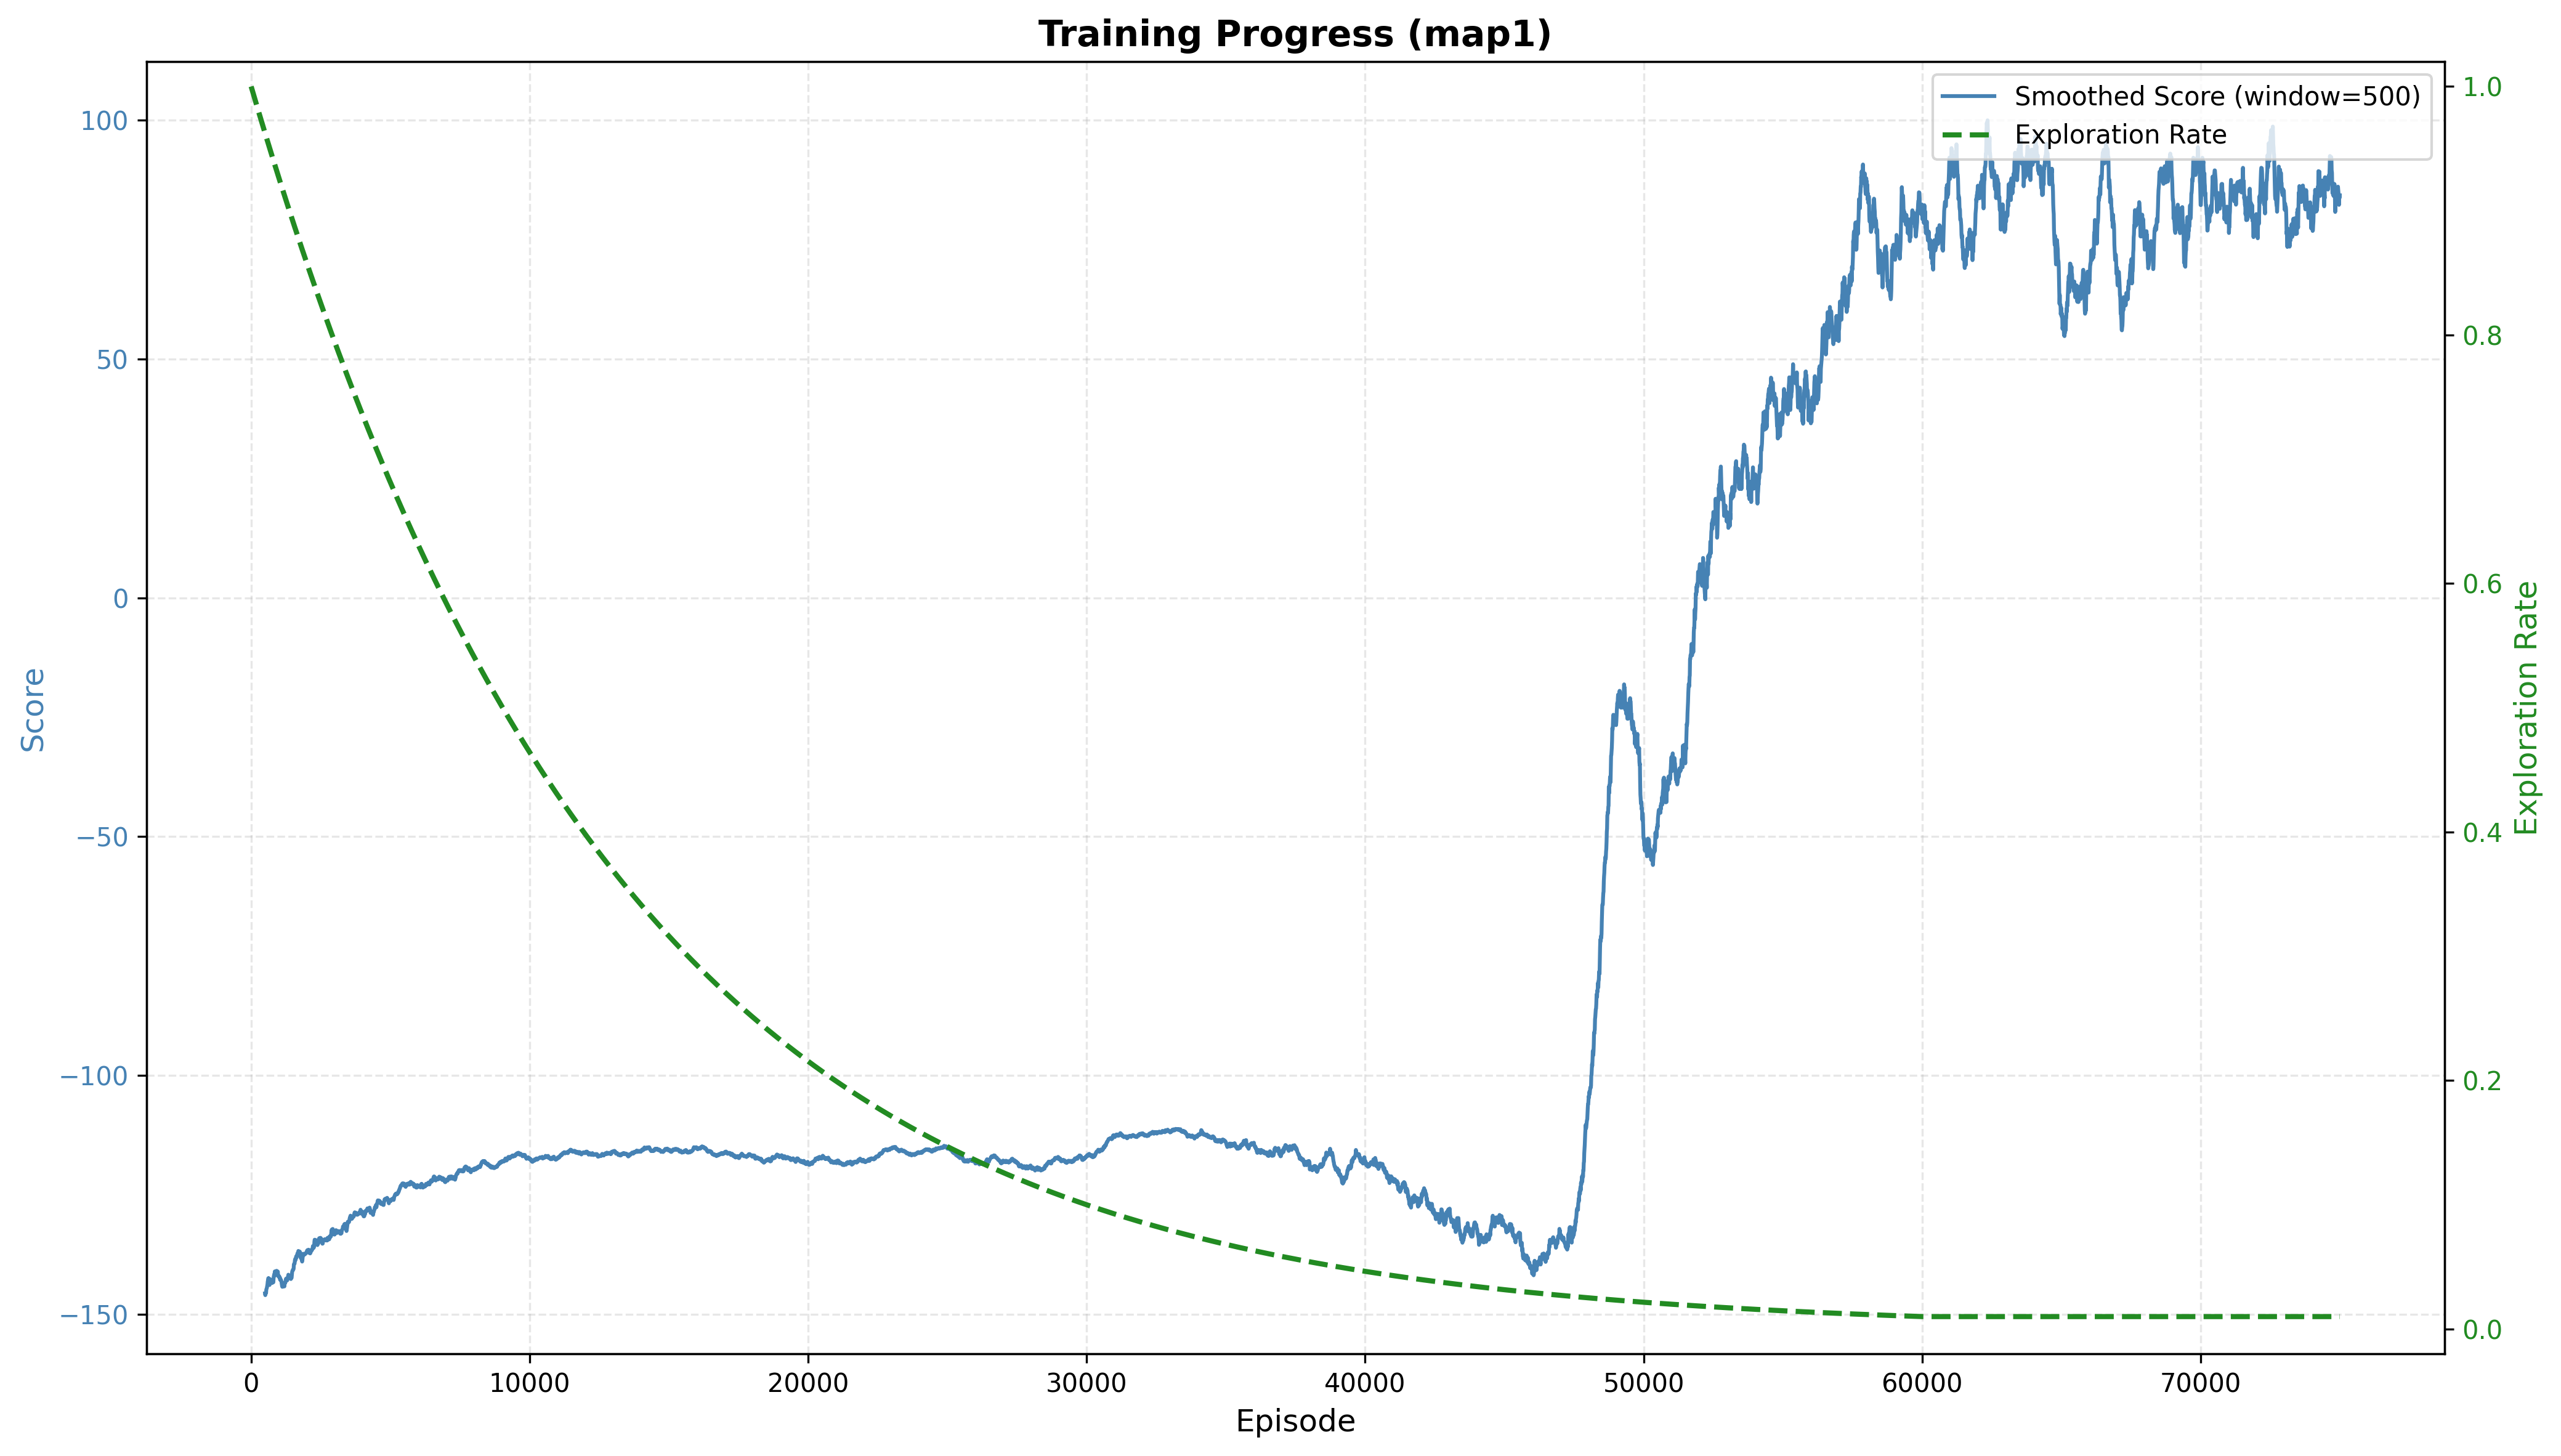

**Interpretacja wykresu:**

Powyższy wykres przedstawia wygładzoną krzywą średnich nagród (niebieska linia, okno wygładzania 500 epizodów) oraz krzywą zanikania współczynnika eksploracji `epsilon` (zielona linia przerywana) w funkcji liczby epizodów treningowych.

*   **Faza Początkowej Eksploracji (ok. 0 - 45000 epizodów):** W początkowej fazie treningu, przy wysokim współczynniku `epsilon` (bliskim 1.0, stopniowo malejącym), agent intensywnie eksploruje środowisko. Średnia nagroda jest niska, oscylująca wokół wartości ujemnych (około -140 do -110). Jest to typowe, ponieważ agent często wpada w pułapki lub wykonuje nieoptymalne ruchy, zanim nauczy się unikać kar i zdobywać pierwsze pozytywne nagrody (np. za zebranie klucza). Widać delikatny trend wzrostowy, co sugeruje, że agent powoli zaczyna odkrywać korzystne stany i akcje.

*   **Faza Przełomowa (ok. 45000 - 55000 epizodów):** Około 45000 epizodu obserwujemy gwałtowny wzrost średniej nagrody. Agent zaczyna regularnie osiągać wyższe wyniki, co wskazuje na odkrycie kluczowych sekwencji działań prowadzących do otwierania drzwi i docierania do celu. W tym okresie `epsilon` jest już na stosunkowo niskim poziomie (poniżej 0.1), co oznacza, że agent częściej wykorzystuje nabytą wiedzę (eksploatacja) niż eksploruje losowo.

*   **Faza Stabilizacji i Optymalizacji (ok. 55000 - 75000 epizodów):** Po gwałtownym wzroście, średnia nagroda stabilizuje się na wysokim poziomie, oscylując w przybliżeniu między +50 a +100. Wahania w tej fazie mogą wynikać z faktu, że agent nadal czasami wybiera suboptymalne ścieżki lub wpada w lokalne minima/maksima funkcji wartości. Współczynnik `epsilon` osiąga swoją minimalną wartość (0.01), co oznacza, że agent niemal wyłącznie eksploatuje nauczoną strategię. Z logów wynika, że pod koniec treningu średnia nagroda oscyluje w okolicach 80-87.

*   **Współczynnik Eksploracji:** Krzywa `epsilon` pokazuje prawidłowe, stopniowe zanikanie od 1.0 do minimalnej wartości 0.01, co jest zgodne z założeniami strategii epsilon-greedy.

Ogólnie, wykres wskazuje, że proces uczenia przebiegł pomyślnie. Agent potrzebował znacznej liczby epizodów na eksplorację złożonego środowiska 20x20 z mechaniką dwóch kluczy i drzwi, ale ostatecznie był w stanie nauczyć się strategii pozwalającej na regularne zdobywanie wysokich nagród.

### 4.3. Obserwacje Zachowania Agenta

Po zakończeniu treningu (75000 epizodów), przeprowadziliśmy serię epizodów demonstracyjnych, aby zaobserwować zachowanie wytrenowanego agenta. Poniżej znajduje się nagranie wideo z jednego z takich przebiegów.

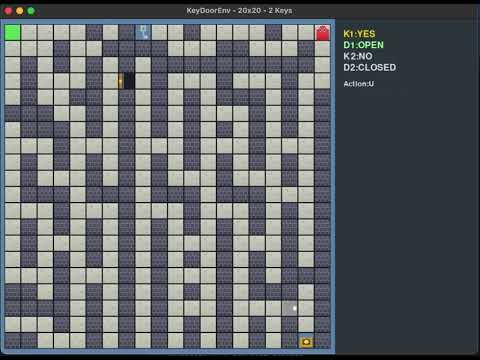

In [7]:
from IPython.display import YouTubeVideo

YouTubeVideo('VErbbUGHQaQ', width=760, height=415)

## 5. Wnioski

Na podstawie przeprowadzonych prac nad implementacją środowiska `KeyDoorEnv` oraz treningiem agenta z wykorzystaniem algorytmu Q-learning, możemy sformułować następujące wnioski.

### 5.1. Podsumowanie Działania Agenta

Przeprowadzone eksperymenty wykazały, że zaimplementowany przez nas agent, uczony za pomocą algorytmu Q-learning, był w stanie **skutecznie nauczyć się rozwiązywać zadanie** postawione w środowisku `KeyDoorEnv` na mapie (20x20). Analiza krzywej uczenia pokazała wyraźny trend wzrostowy, stabilizujący się na wysokim poziomie, co świadczy o nabywaniu przez agenta coraz lepszej strategii.

Wytrenowany agent w fazie demonstracyjnej konsekwentnie osiągał wysokie wyniki (np. 219 punktów przy 141 krokach), co potwierdza, że opanował wymaganą sekwencję działań: zebranie pierwszego klucza, otwarcie pierwszych drzwi, zebranie drugiego klucza, otwarcie drugich drzwi, a następnie dotarcie do celu. Agent nauczył się również efektywnie unikać pułapek i minimalizować liczbę zbędnych ruchów, co przekłada się na optymalizację ścieżki.

## 6. Załączniki


### GitHub

🔗 [**Repozytorium projektu**](https://github.com/PiotrWaluszek/key-door/tree/main)